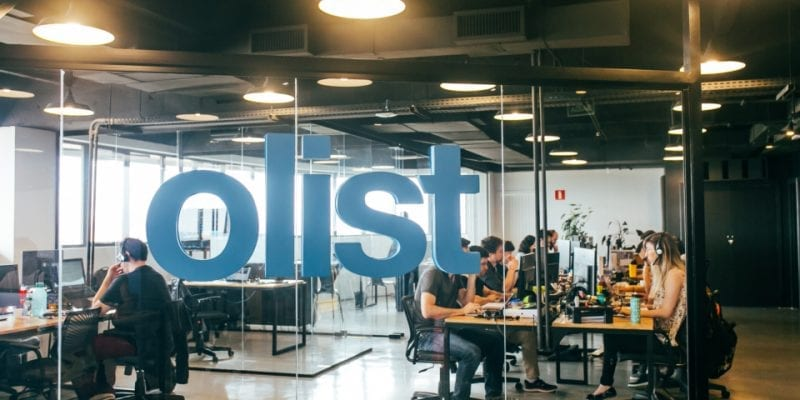

# Brazilian E-Commerce Olist Customers Segmentation

Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

In [161]:
# ! usr/bin/env python 3
# coding: utf-8

# Importing librairies

from sklearn.preprocessing import StandardScaler
from IPython.display import HTML
import numpy as np               # numerical data processing
import pandas as pd              # numerical tables & time series
import scipy as sp
# numerical integration, interpolation, optimization and statistics
import scipy.stats as st         # statistical functions
import seaborn as sns            # statistical data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objs as go
# static, animated, and interactive visualizations in Python
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn.metrics import silhouette_samples, silhouette_score, \
                            adjusted_rand_score
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import time
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

__FONCTION DEFINED TO HELP DESCRIBING THE CHARACTERISTICS OF THE INPUT FILES__

In [101]:
# Transforming our input files.csv from the cleaning phase to dataframe

custom_order = pd.read_csv('custom_order.csv')
df_rfm = pd.read_csv('rfm.csv')

## 1. INPUT FILES OVERVIEW 

In [102]:
df_rfm

,customer_id,recency,monetary,frequency
0,00012a2ce6f8dcda20d059ce98491703,287,114.74,1
1,000161a058600d5901f007fab4c27140,409,67.41,1
2,0001fd6190edaaf884bcaf3d49edf079,547,195.42,1
3,0002414f95344307404f0ace7a26f1d5,378,179.35,1
4,000379cdec625522490c315e70c7a9fb,149,107.01,1
...,...,...,...,...
95827,fffcb937e9dd47a13f05ecb8290f4d3e,165,91.91,1
95828,fffecc9f79fd8c764f843e9951b11341,152,81.36,1
95829,fffeda5b6d849fbd39689bb92087f431,99,63.13,1
95830,ffff42319e9b2d713724ae527742af25,76,214.13,1


Let's add 2 new features to our RFM table

In [103]:
delivery = custom_order.groupby("customer_id")["average_delivery_days"].mean()
delivery.max()

208.0

In [105]:
review = custom_order.groupby("customer_id")["review_score"].mean()
review.shape

(95832,)

In [106]:
df_rfm = pd.merge(pd.merge(df_rfm, 
                           delivery, on='customer_id'),
                           review, on='customer_id')
df_rfm.rename(columns={"average_delivery_days": "delivery"}, inplace=True)
df_rfm.rename(columns={"review": "review_score"}, inplace=True)
## df_rfm.reset_index()
df_rfm.describe()
df_rfm.shape

(95832, 6)

1:35: W291 trailing whitespace
3:28: E127 continuation line over-indented for visual indent
6:1: E266 too many leading '#' for block comment


In [107]:
df_rfm.describe()

,recency,monetary,frequency,delivery,review_score
count,95832.000000,95832.000000,95832.000000,95824.000000,95832.000000
mean,238.970928,160.293483,1.147978,12.052273,4.156187
std,152.862104,218.335925,0.550717,9.466046,1.283622
min,0.000000,9.590000,1.000000,0.000000,1.000000
25%,115.000000,62.010000,1.000000,6.000000,4.000000
50%,220.000000,105.380000,1.000000,10.000000,5.000000
75%,349.000000,176.880000,1.000000,15.000000,5.000000
max,713.000000,13664.080000,22.000000,208.000000,5.000000


In [117]:
df_rfm = df_rfm[df_rfm['delivery'] !=0]
# df_rfm.to_csv('test.csv')
df_rfm = df_rfm.set_index('customer_id')
df_rfm.describe()

,recency,monetary,frequency,delivery,review_score
count,95811.000000,95811.000000,95811.000000,95811.000000,95811.000000
mean,238.974095,160.291379,1.147958,12.053908,4.156148
std,152.857382,218.347049,0.550550,9.465647,1.283627
min,0.000000,9.590000,1.000000,1.000000,1.000000
25%,115.000000,62.010000,1.000000,6.000000,4.000000
50%,220.000000,105.380000,1.000000,10.000000,5.000000
75%,349.000000,176.880000,1.000000,15.000000,5.000000
max,713.000000,13664.080000,22.000000,208.000000,5.000000


1:38: E225 missing whitespace around operator


In [118]:
df_rfm

,recency,monetary,frequency,delivery,review_score
customer_id,,,,,
00012a2ce6f8dcda20d059ce98491703,287,114.74,1,13.0,1.0
000161a058600d5901f007fab4c27140,409,67.41,1,9.0,4.0
0001fd6190edaaf884bcaf3d49edf079,547,195.42,1,5.0,5.0
0002414f95344307404f0ace7a26f1d5,378,179.35,1,28.0,5.0
000379cdec625522490c315e70c7a9fb,149,107.01,1,11.0,4.0
...,...,...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,165,91.91,1,4.0,5.0
fffecc9f79fd8c764f843e9951b11341,152,81.36,1,12.0,3.0
fffeda5b6d849fbd39689bb92087f431,99,63.13,1,17.0,4.0


### Distribution of variables

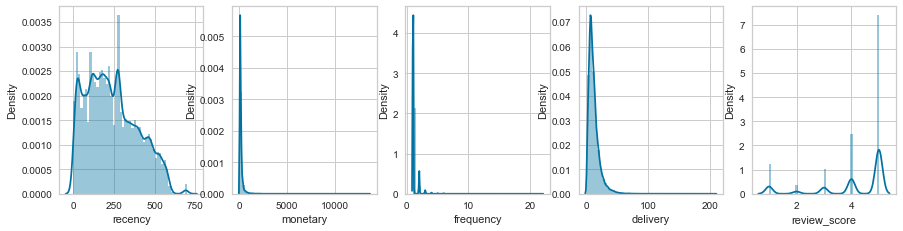

In [119]:
fig = plt.figure(figsize=(15, 20))

ax = fig.add_subplot(551)
sns.distplot(df_rfm['recency'], ax=ax)

ax = fig.add_subplot(552)
sns.distplot(df_rfm['monetary'], ax=ax)

ax = fig.add_subplot(553)
sns.distplot(df_rfm['frequency'], ax=ax)

ax = fig.add_subplot(554)
sns.distplot(df_rfm['delivery'], ax=ax)

ax = fig.add_subplot(555)
sns.distplot(df_rfm['review_score'], ax=ax)

plt.show()

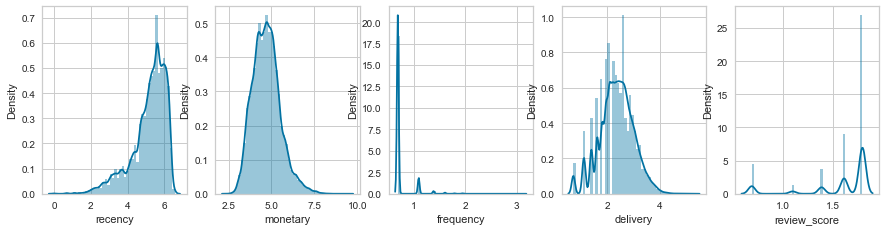

In [120]:
fig = plt.figure(figsize=(15, 20))
df_rfm_log = np.log1p(df_rfm)
ax = fig.add_subplot(551)
sns.distplot(df_rfm_log['recency'], ax=ax)

ax = fig.add_subplot(552)
sns.distplot(df_rfm_log['monetary'], ax=ax)

ax = fig.add_subplot(553)
sns.distplot(df_rfm_log['frequency'], ax=ax)

ax = fig.add_subplot(554)
sns.distplot(df_rfm_log['delivery'], ax=ax)

ax = fig.add_subplot(555)
sns.distplot(df_rfm_log['review_score'], ax=ax)
plt.show()

In [121]:
scaler = StandardScaler()
# scaler = Quantiletransformer()
scaler.fit(df_rfm_log)
df_rfm_log.describe()

,recency,monetary,frequency,delivery,review_score
count,95811.000000,95811.000000,95811.000000,95811.000000,95811.000000
mean,5.167145,4.705619,0.746007,2.368253,1.594148
std,0.946242,0.800171,0.170277,0.636150,0.336407
min,0.000000,2.359910,0.693147,0.693147,0.693147
25%,4.753590,4.143293,0.693147,1.945910,1.609438
50%,5.398163,4.667018,0.693147,2.397895,1.791759
75%,5.857933,5.181109,0.693147,2.772589,1.791759
max,6.570883,9.522599,3.135494,5.342334,1.791759


In [122]:
# std @1 and mean@0
rfm_log_scaled = scaler.transform(df_rfm_log)
rfm_log_scaled = pd.DataFrame(rfm_log_scaled, columns=df_rfm_log.columns)
round(rfm_log_scaled.describe(), 2)
# RFM_Table_scaled

,recency,monetary,frequency,delivery,review_score
count,95811.00,95811.00,95811.00,95811.00,95811.00
mean,-0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
min,-5.46,-2.93,-0.31,-2.63,-2.68
25%,-0.44,-0.70,-0.31,-0.66,0.05
50%,0.24,-0.05,-0.31,0.05,0.59
75%,0.73,0.59,-0.31,0.64,0.59
max,1.48,6.02,14.03,4.68,0.59


In [123]:
rfm_log_scaled

,recency,monetary,frequency,delivery,review_score
0,0.523987,0.057147,-0.310432,0.425695,-2.678322
1,0.897252,-0.600000,-0.310432,-0.103228,0.045451
2,1.203854,0.718145,-0.310432,-0.906228,0.587422
3,0.814164,0.611472,-0.310432,1.570461,0.587422
4,-0.165402,-0.029238,-0.310432,0.183375,0.045451
...,...,...,...,...,...
95806,-0.058291,-0.217440,-0.310432,-1.192832,0.587422
95807,-0.144474,-0.368073,-0.310432,0.309200,-0.617867
95808,-0.593904,-0.680742,-0.310432,0.820752,0.045451
95809,-0.870119,0.831855,-0.310432,-0.906228,0.587422


## K-Means

The k-means clustering method is an unsupervised machine learning technique used to identify clusters of data objects in a dataset. K-means requires only a few steps. The first step is to randomly select k centroids, where k is equal to the number of clusters you choose. Centroids are data points representing the center of a cluster.

The main element of the algorithm works by a two-step process called expectation-maximization. The expectation step assigns each data point to its nearest centroid. Then, the maximization step computes the mean of all the points for each cluster and sets the new centroid.

In [126]:
numerical_features = list(df_rfm.columns)

scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

### Elbow Method

The elbow method runs k-means clustering on the dataset for a range of values for k (here 2 to 10) and then for each value of k computes an average score for all clusters. By default, the distortion score is computed, the sum of square distances (ssd) from each point to its assigned center.

### KElbowVisualizer

The KElbowVisualizer implements the “elbow” method to help data scientists select the optimal number of clusters by fitting the model with a range of values for K. If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. In the visualizer “elbow” will be annotated with a dashed line.

To demonstrate, in the following example the KElbowVisualizer fits the KMeans model for a range of K values from 2 to 9 on our dataset. When the model is fit with 5 clusters, we can see a line annotating the “elbow” in the graph, which in this case we know to be the optimal number.

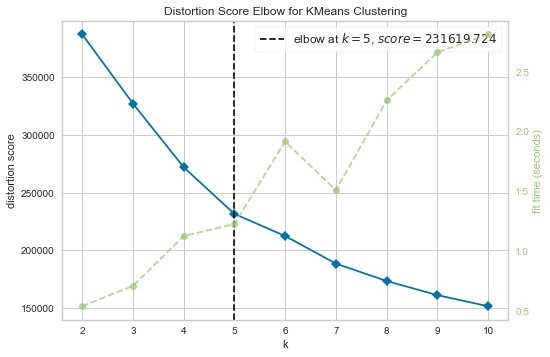

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

6:51: E231 missing whitespace after ','
6:56: E231 missing whitespace after ','


In [138]:
X = df_rfm.copy()

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(), K=(4, 12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

#### LOG SCALE

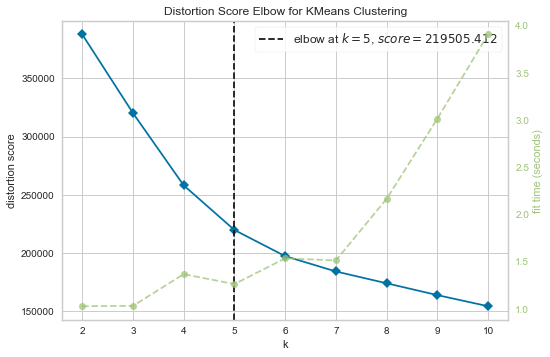

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [142]:
logX = np.log1p(X)

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(), K=(4, 12)))])
kmeans_visualizer.fit(logX)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

### Silhouette Analysis

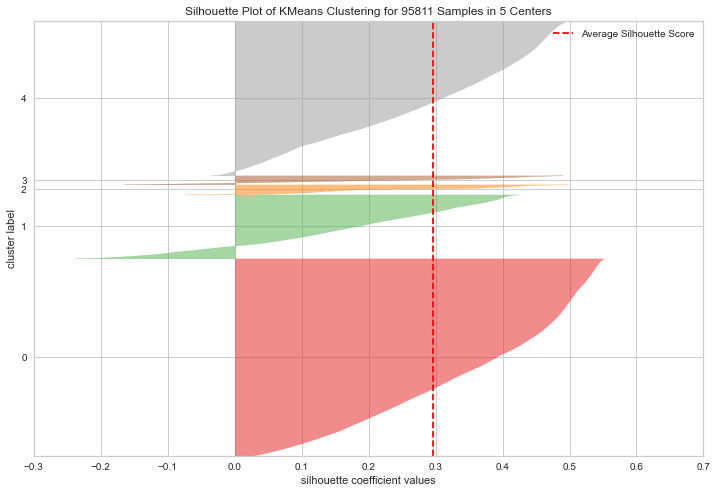

In [139]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
fig = plt.figure(figsize=(12, 8))
# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()
plt.show()

#### LOG SCALE

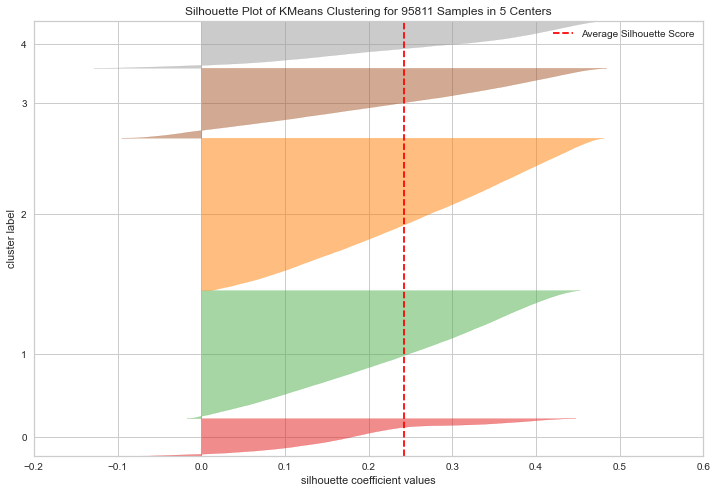

2:25: W291 trailing whitespace


Time to run: 346.6148045063019


In [144]:
# Best K in Elbow
start_time = time.time() 

K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
fig = plt.figure(figsize=(12, 8))
# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(logX)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()
tm = time.time() - start_time
plt.show()
print('Time to run:', tm)

### Calinski-Harabasz

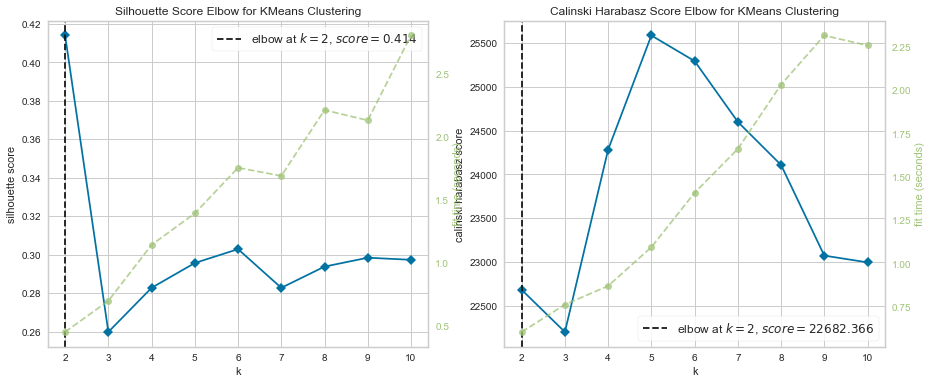

5:80: E501 line too long (86 > 79 characters)
5:83: E231 missing whitespace after ','


In [140]:
# Elbow method with differents metrics
metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,6))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(2, 10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(X)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i += 1
plt.show()

#### LOG SCALE

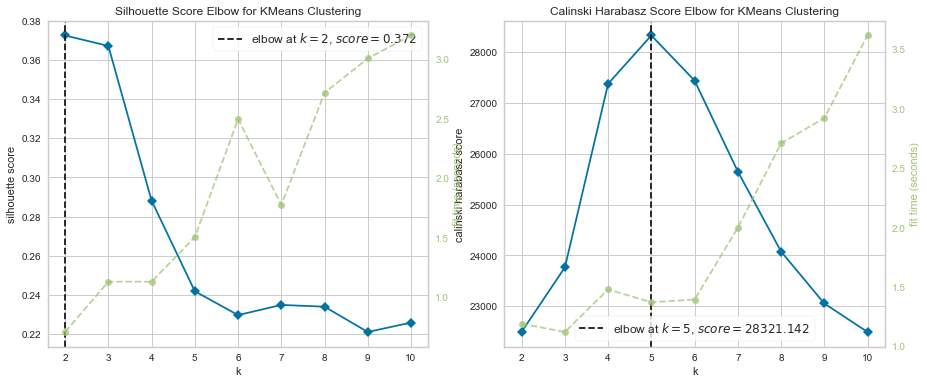

8:80: E501 line too long (86 > 79 characters)
8:83: E231 missing whitespace after ','
19:1: W293 blank line contains whitespace


Time to run (s): 1699.5843811035156


In [147]:
# Elbow method with differents metrics

start_time = time.time()

metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15,6))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(2, 10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(logX)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i += 1
    
tm = time.time() - start_time
plt.show()
print('Time to run (s):', tm)

### Distance intercluster

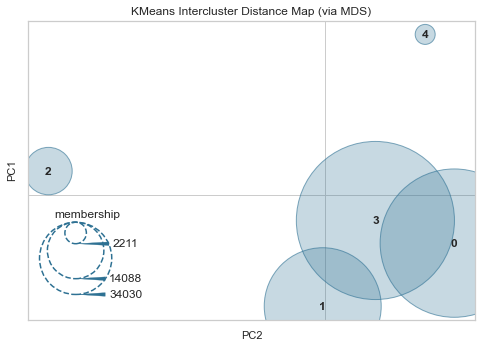

In [145]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()
plt.show()

#### LOG SCALE

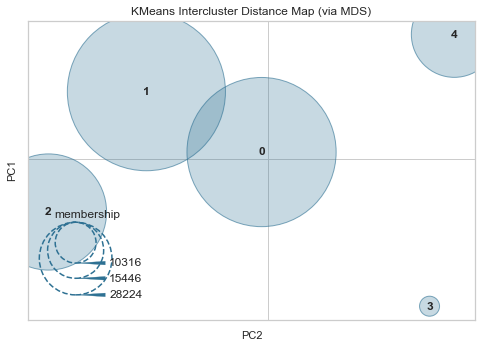

In [146]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(logX)
distance_visualizer.named_steps['distancevisualizer'].show()
plt.show()

### KMeans Pipeline with best K

In [148]:
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
df_rfm["kmeans_label"] = kmeans_labels

In [149]:
kmeans_clusters_means = df_rfm.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

,kmeans_label,recency,monetary,frequency,delivery,review_score
0,0,390.151728,130.851807,1.074321,11.163130,4.601152
1,1,237.270106,1223.507860,1.149216,13.417299,4.193222
2,2,122.646185,129.215633,1.066363,9.464956,4.647588
3,3,233.526824,150.359781,1.151717,22.160020,1.666371
4,4,237.378562,337.421633,3.861601,11.071461,3.473617


In [150]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

,recency,monetary,frequency,delivery,review_score
kmeans_label,,,,,
0,0.989016,-0.134830,-0.133752,-0.094107,0.346679
1,-0.011148,4.869413,0.002285,0.144036,0.028883
2,-0.761026,-0.142323,-0.148207,-0.273512,0.382855
3,-0.035636,-0.045486,0.006828,1.067668,-1.939652
4,-0.010438,0.811237,4.928991,-0.103791,-0.531723


In [173]:

def plot_radars(data, group):

    scaler = StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))
        
    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Clusters features comparaison",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="black",
        title_font_size=18)

    fig.show()

In [174]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

#### LOG SCALE

In [163]:
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(logX)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
df_rfm_log["kmeans_label"] = kmeans_labels

In [164]:
kmeans_clusters_means = df_rfm_log.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

,kmeans_label,recency,monetary,frequency,delivery,review_score
0,0,5.296497,5.257531,1.221703,2.295905,1.575324
1,1,5.579414,4.095591,0.693183,2.210910,1.709566
2,2,3.567411,4.604798,0.702342,1.884381,1.707955
3,3,5.466069,5.301393,0.693176,2.647537,1.703136
4,4,5.294381,4.778819,0.746309,2.900539,0.766188


In [165]:
logX_scaled = preprocessor.fit_transform(logX)
logX_scaled = pd.DataFrame(logX_scaled, index=X.index, columns=X.columns)
logX_scaled["kmeans_label"] = kmeans_labels
logX_scaled_clusters = logX_scaled.groupby("kmeans_label").mean()
logX_scaled_clusters

,recency,monetary,frequency,delivery,review_score
kmeans_label,,,,,
0,0.136702,0.689746,2.793669,-0.113728,-0.055956
1,0.435694,-0.762376,-0.310220,-0.247337,0.343094
2,-1.690627,-0.126000,-0.256432,-0.760631,0.338303
3,0.315908,0.744561,-0.310263,0.439024,0.323980
4,0.134466,0.091481,0.001775,0.836734,-2.461200


In [172]:
plot_radars(data=logX_scaled_clusters,
            group="kmeans_label")

### HDBSCAN

HDBSCAN - Hierarchical Density-Based Spatial Clustering of Applications with Noise. Performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability over epsilon. This allows HDBSCAN to find clusters of varying densities (unlike DBSCAN), and be more robust to parameter selection.

In [ ]:
df_rfm_log

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=12,
                            metric='euclidean')
clusterer.fit(rfm_log_scaled[['recency', 'frequency', 'monetary']])
df_rfm['Cluster'] = pd.Series(clusterer.labels_, index=rfm_log_scaled.index)

df_rfm.head(5)

In [ ]:
len(df_rfm['Cluster'].unique())-1

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.colors as mcolors
fig = plt.figure(figsize=(18,12))
dx = fig.add_subplot(111, projection='3d')

for i in range(-1,len(df_rfm['Cluster'].unique())-1):
    dx.scatter(df_rfm[df_rfm.Cluster == i].frequency,
                     df_rfm[df_rfm.Cluster == i].recency,
                     df_rfm[df_rfm.Cluster == i].monetary,
                     label = 'Cluster ' + str(i),
                     s=10, alpha=1.0)
dx.set_xlabel('Frequency', fontsize=14)
dx.set_ylabel('Recency', fontsize=14)
dx.set_zlabel('Monetary', fontsize=14)
dx.legend(fontsize=12)
plt.show()

In [ ]:
pd.Series(clusterer.labels_).value_counts()

### NEW TSNE LOG SCALE

In [89]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

In [90]:
# create a numpy matrix by concatenation of train and test datasets
X = df_rfm_log.values

In [91]:
time_start = time.time()

X_TSNE = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 1382.2591445446014 seconds


In [92]:
df_TSNE = pd.DataFrame.from_records(X_TSNE)
print(df_TSNE.shape)
df_TSNE.head()

(95824, 2)


,0,1
0,-52.124966,-13.560540
1,20.754723,29.631758
2,-7.955591,34.816692
3,26.749912,-9.744322
4,3.305401,-0.025689


In [93]:
clust_series = pd.Series(clust)

NameError: name 'clust' is not defined

In [ ]:
df_TSNE = df_TSNE.assign(cluster = clust_series)

print(df_TSNE.columns, df_TSNE.shape)
df_TSNE = df_TSNE.rename(columns={0: 'TSNE_1', 1: 'TSNE_2'})
df_TSNE["cluster"].replace({0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 42: "Test values"}, inplace=True)
df_TSNE.head()

In [ ]:
df_TSNE["cluster"].value_counts()

In [ ]:
orderhue= ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Test values']
sns.lmplot(x = 'TSNE_1', y = 'TSNE_2', data = df_TSNE, fit_reg = False, legend = True, size = 10, hue = "cluster", hue_order= orderhue, scatter_kws={"s":200, "alpha":0.15} )
plt.xlabel('TSNE component 1', fontsize = 14)
plt.ylabel('TSNE component 2', fontsize = 14)
plt.title('Data clustered with K-Means and plotted in 2D after T-SNE dimensional reduction', fontsize = 20)
plt.show()